## Notebook 1: Segmentation of satellite images of water bodies using deep learning models with Keras in TensorFlow

The dataset used in this notebook is a collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water. The masks were created to detect and measure vegetation in satellite images.

In this notebook, I used built-in Keras Sequential model with and without data augmentation technique to perform segmentation of satellite images of water bodies.

**1. Prepare Problem**

In [1]:
# a) Load libraries

from numpy import asarray
import numpy as np

import os
import cv2
import glob
import imagehash
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# b) Load dataset

images = sorted(glob.glob("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes/*.jpg"))
masks = sorted(glob.glob("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Masks/all_classes/*.jpg"))

print(len(images), len(masks))

2841 2841


In total, there are 2,841 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

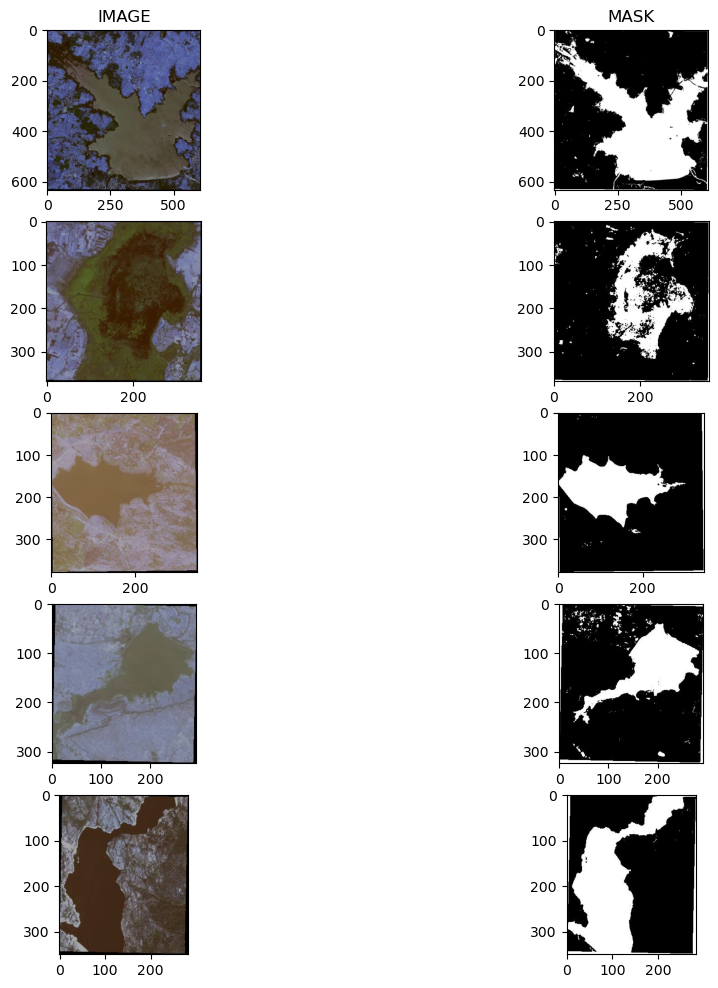

In [3]:
# a) Image visualization
# plot first few random images in Images and Masks folder
f, axr = plt.subplots(5,2, figsize=(12,12))
for i in range(5):
    idx = np.random.randint(0, len(images))
    original = cv2.imread(images[idx])
    mask = cv2.imread(masks[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different shapes. The differences in shape between the images and masks may present challenges during the transformation and training processes.

In [4]:
#Detect duplicate images and masks
hashes = {}
to_remove = []

for file in images:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)
            # Check if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file

Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1244.jpg and C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1023.jpg
Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1333.jpg and C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1023.jpg
Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1552.jpg and C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1023.jpg
Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1619.jpg and C:/Users/s

After removing 17 duplicate images and their corresponding masks, new lists of images and masks were created for the next stage of data processing.

In [5]:
# Create a new list of filenames that excludes the duplicates
new_images = [file for file in images if file not in to_remove]
new_masks = [os.path.join("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes", os.path.basename(file)) for file in new_images]
print(len(new_images), len(new_masks))

2824 2824


Let's examine the statistical figures of the dataset to understand how the dimensions are distributed among the images. This will help us identify any abnormal size images that can be filtered out to improve training performance.

In [6]:
# Calculate statistics of the image dimensions
dimen_img_list = []

for img in new_images:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# Convert the list to numpy array
dimen_img_array = np.array(dimen_img_list)   

In [7]:
# Calculate statistics of the image dimensions
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 443.39270538243625
Median width: 259.0
Standard deviation of width: 551.388001839767
Minimum height: 7
Maximum height: 7093
Mean height: 557.0417847025495
Median height: 333.0
Standard deviation of height: 683.8900990053114


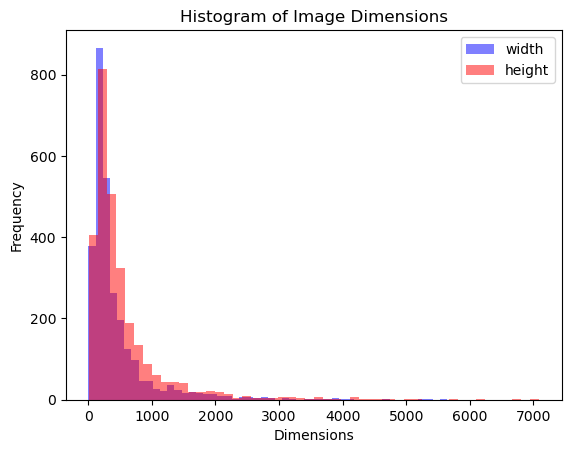

In [8]:
# Plot the histogram
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

The statistical result suggests that the median values of height and width of the images are around 300 pixels and therefore, it would be advisable to resize all images and masks to this size or larger to ensure good training performance. To filter out any images with abnormal sizes, a cut-off threshold of 32 pixels (which is 10% of the median value) will be applied.

**3. Prepare Data**

In [9]:
# a) Load, filter blank and abnormal size images and masks, and resize them to the median values or larger ones 

min_size = 32
df_images = []
df_masks = []

height = width = 300

for image, mask in zip(new_images, new_masks):
    #cv2.imread reads image in BGR, we need to convert it back to the standard mode RGB 
    n = cv2.imread(image, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    if (np.sum(n) > 0) and (np.sum(m) > 0) and (min(n.shape[:2]) > min_size):
        n = cv2.resize(n, (height, width)) # resize to median values or larger ones
        df_images.append(n)
        m = cv2.resize(m, (height, width)) # resize to median values or larger ones
        df_masks.append(m)

# Convert image into array of pixels
df_images = asarray(df_images)

# Convert mask into array of pixels
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2802 2802


In total, 22 images and their corresponding masks were removed from the dataset, leaving a total of 2802 samples for training, testing, and validation.

In [10]:
# b) Split data into train and test sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2101, 300, 300, 3) (2101, 300, 300) (690, 300, 300, 3) (690, 300, 300) (11, 300, 300, 3) (11, 300, 300)


In [11]:
# Flatten images and convert data from numpy array to float type

X_train = X_train.reshape(X_train.shape[0], height, width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], height, width, 3).astype('float32')
X_val = X_val.reshape(X_val.shape[0], height, width, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], height, width).astype('float32')
y_test = y_test.reshape(y_test.shape[0], height, width).astype('float32')
y_val = y_val.reshape(y_val.shape[0], height, width).astype('float32')


In [12]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
y_train = y_train / 255
y_test = y_test / 255
y_val = y_val / 255

**4. Evaluate Models**

In [13]:
# a) Define Keras Sequential model

def base_model():
    model = Sequential()
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error')
    return model

# Build the model
model = base_model()

In [14]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [15]:
# Fit the model to train and test sets
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
66/66 [==============================] - 571s 9s/step - loss: 0.0370 - val_loss: 0.0124
Epoch 2/30
66/66 [==============================] - 561s 9s/step - loss: 0.0076 - val_loss: 0.0016
Epoch 3/30
66/66 [==============================] - 569s 9s/step - loss: 0.0038 - val_loss: 7.4082e-04
Epoch 4/30
66/66 [==============================] - 564s 9s/step - loss: 0.0033 - val_loss: 3.9593e-04
Epoch 5/30
66/66 [==============================] - 560s 9s/step - loss: 0.0031 - val_loss: 2.0253e-04
Epoch 6/30
66/66 [==============================] - 564s 9s/step - loss: 0.0029 - val_loss: 1.2043e-04
Epoch 7/30
66/66 [==============================] - 569s 9s/step - loss: 0.0028 - val_loss: 9.1573e-05
Epoch 8/30
66/66 [==============================] - 588s 9s/step - loss: 0.0027 - val_loss: 6.3664e-05
Epoch 9/30
66/66 [==============================] - 571s 9s/step - loss: 0.0026 - val_loss: 5.3447e-05
Epoch 10/30
66/66 [==============================] - 569s 9s/step - loss: 0.0025 

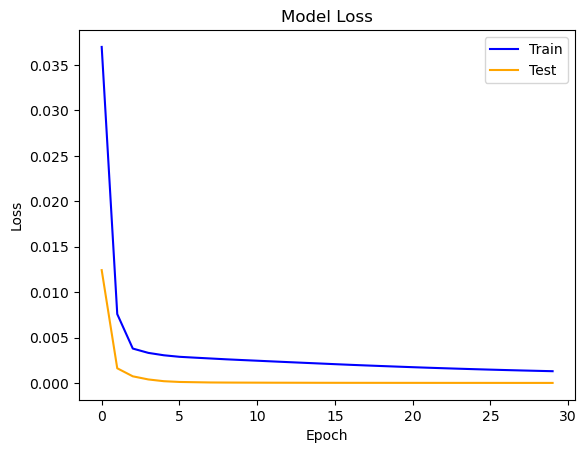

In [16]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

The loss values of training and validation are in good agreement and are perfectly accurate for such a simple CNN model.

**4. Improved Baseline Models**

In this section, we aims at improving the baseline model by applying image augmentation.

In [17]:
# Create a generator that performs simple augmentation on the baseline image, 
# specifically horizontal flips and 10% shifts in the height and width of the images in train and test sets.

gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [18]:
# Prepare iterators for each dataset
train_gen = gen.flow(X_train, y_train, batch_size=32)
test_gen = gen.flow(X_test, y_test, batch_size=32)

In [19]:
# Define Keras Sequential model with a Dropout layer to avoid overfitting
def improved_model():
    model2 = Sequential()
    model2.add(Dense(200, activation='relu'))
    model2.add(Dropout(0.3))
    model2.add(Dense(1))
    model2.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error')
    return model2

# Build the model
model2 = improved_model()

In [20]:
# Fit the model
history2 = model2.fit(train_gen, epochs=30, batch_size=32, validation_data=test_gen, callbacks=[early_stopping])

Epoch 1/30
66/66 [==============================] - 569s 9s/step - loss: 0.0860 - val_loss: 0.0518
Epoch 2/30
66/66 [==============================] - 571s 9s/step - loss: 0.0367 - val_loss: 0.0248
Epoch 3/30
66/66 [==============================] - 571s 9s/step - loss: 0.0235 - val_loss: 0.0201
Epoch 4/30
66/66 [==============================] - 573s 9s/step - loss: 0.0222 - val_loss: 0.0198
Epoch 5/30
66/66 [==============================] - 569s 9s/step - loss: 0.0219 - val_loss: 0.0194
Epoch 6/30
66/66 [==============================] - 594s 9s/step - loss: 0.0215 - val_loss: 0.0191
Epoch 7/30
66/66 [==============================] - 581s 9s/step - loss: 0.0213 - val_loss: 0.0189
Epoch 8/30
66/66 [==============================] - 573s 9s/step - loss: 0.0211 - val_loss: 0.0189
Epoch 9/30
66/66 [==============================] - 571s 9s/step - loss: 0.0206 - val_loss: 0.0185
Epoch 10/30
66/66 [==============================] - 572s 9s/step - loss: 0.0208 - val_loss: 0.0183
Epoch 11/

We can see that contrary to what we would have hoped of a further lift in model performance, the new model performs worse than the baseline one. 

Using both dropout regularization and data augmentation techniques together hasn't improved model's performance which can be explained by (1) the size and complexity of the dataset, and (2) possibly some extent of overfitting from the data augmentation.

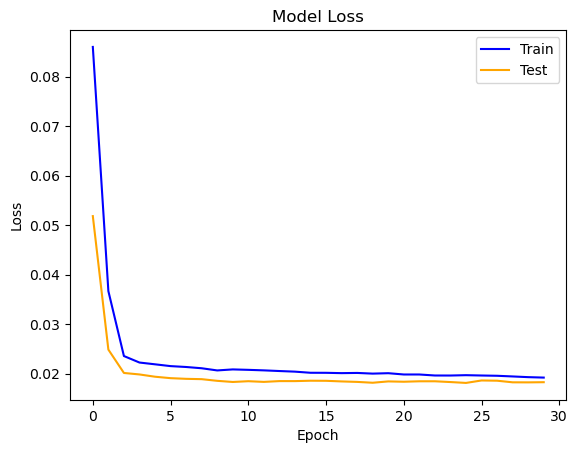

In [21]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

Since the new model underperforms the baseline one, we will use the baseline model for prediction and finalization.

**5. Finalize Model**

1/1 [==============================] - 0s 358ms/step


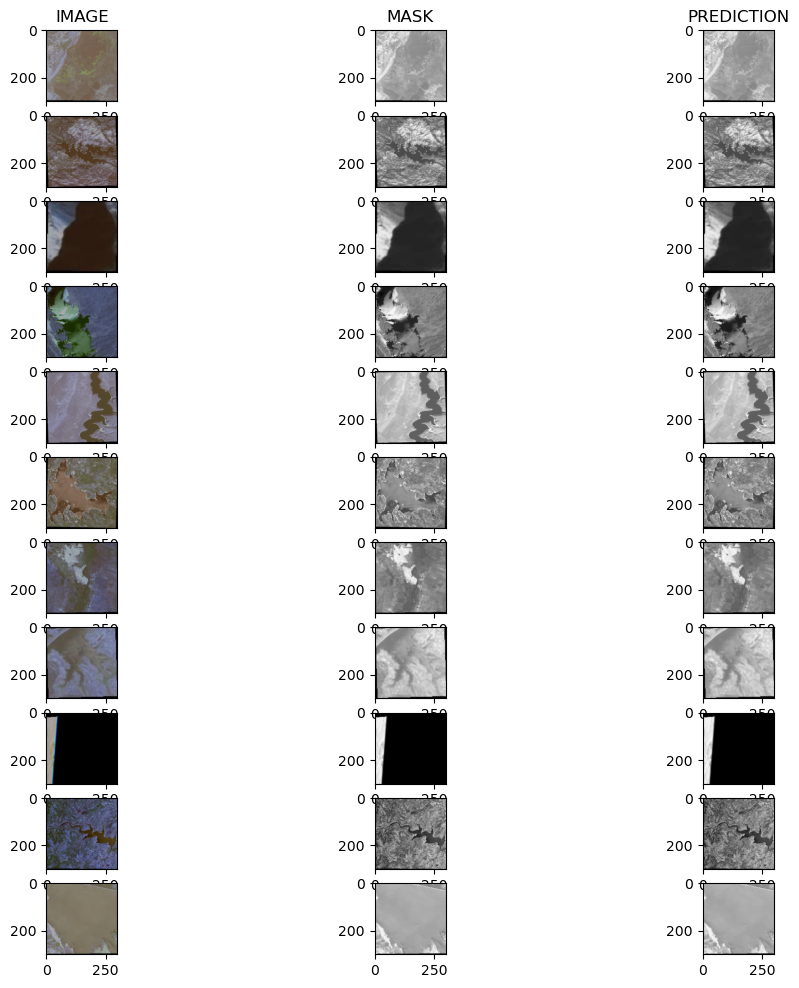

In [23]:
# a) Predictions on validation data
Pred = model.predict(X_val)

# Plot original and predicted images
fig, ax = plt.subplots(11, 3, figsize=(12,12))
for i in range(11):
    orig = X_val[i]
    msk = y_val[i]
    pred = Pred[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(pred, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

The predicted images closely resemble the original images and masks, which suggests a high level of accuracy in the prediction.

In [ ]:
# b) Save the model for later use

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

**6. Conclusions**

- Data cleaning is essential to remove duplicate, blank and abnormal size images before passing into the CNN model for segmentation.

- Satellite image introduce additional challenges, such as different sizes, resolutions, and details of objects to be detected, compared to common images.

- This simple CNN model with one hidden layer can accurately detect and reproduce the shape of most water bodies in the image and mask dataset, evidenced by very low validation loss of 1.3899e-05. 

- The use of dropout regularization and data augmentation doesn't improve the performance of the model owing to the size and complexity of the dataset, and possibly some extent of overfitting from the data augmentation.

- The model performance can be improved by using large and pre-trained models (such as ResNet-50) and will be covered in the second Notebook of this repository.